# 50:50 beads

In [2]:
from labvision.video import ReadVideo
from labvision.images import display, threshold, median_blur
from labvision.images.cropmask import mask_circle, apply_mask
from particletracker import batchprocess, track_gui
from filehandling import BatchProcess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Fig 2 analysis

We track the position of the bead using particletracker and use the position data relative to centre of cell to create a heatmap.
We also calcualte the fraction of blue visible to the camera. Fluctuations in this fraction tell us about rotation and also whether the charging is resulting in a downwards correlation resulting from charge imbalance on the two sides.

Next bits create raw data

### Tracking

The mask moves in these movies. Original mask ((1096, 532), (1560, 844))
track_5050.param uses this.

In [9]:
# Track the position of the beads
path='E:/RawData/Mike/5050_beads/'
filename='P1001910.mp4'
settings = 'track_5050b.param'
track_gui(path + filename, path + settings)
#batchprocess(path + filename, path + settings)

Empty DataFrame
Columns: []
Index: []


Annotating: 100%|██████████| 1/1 [00:00<00:00, 333.57it/s]


Empty DataFrame
Columns: []
Index: []


Annotating: 100%|██████████| 1/1 [00:00<00:00, 333.36it/s]


### 50:50

Movies filmed on 11th Oct use different mask.

Original mask = ((1096, 532), (1560, 844)) 10/10/2023 and earlier (track_5050.param)

Later_mask = ((774, 488), (1275, 798)) for all 11/10/2023 (track50_50b.param)

Final_mask = ((865, 493), (1354, 805)) for movies on the 13/10/2023 (track50_50c.param)



In [22]:
#Calculate the fraction of blue in the image
def fraction_blue(img):
    mask = ((865, 493), (1354, 805))
    mask_img = mask_circle(np.shape(img[:,:,0]), mask)
    img = median_blur(img)
    red_img=apply_mask(threshold(img[:,:,2], value=112), mask_img)
    #display(red_img)
    blue_img=apply_mask(threshold(img[:,:,0], value=100),mask_img)
    fraction = np.sum(np.sum(red_img))/(np.sum(np.sum(blue_img)))
    return fraction

def calc_charge(df, dq_blue=-0.00253333333, dq_white=-0.00656666666):
    # Bounces on white occur when fraction is less than 0.5 (ie blue facing up). If fraction
    # = -1 (no measurement) then charge_white / blue add nothing.
    charge_blue = np.cumsum(df['fraction'].to_numpy() >= 0.5) * dq_blue
    charge_white = np.cumsum((df['fraction'].to_numpy() < 0.5) & (df['fraction'].to_numpy() >=0)) * dq_white
    

    df['charge_blue'] = charge_blue
    df['charge_white'] = charge_white
    return df

def process_5050(filepath):
    vid = ReadVideo(filepath, frame_range=(0, None, 1))
    fraction_data = pd.DataFrame(index=np.linspace(0,vid.num_frames-1, vid.num_frames, dtype=int), data=np.zeros(vid.num_frames))
    #Fraction = -1 means no measurement was made
    fraction_data['fraction']=-1
    for idx, frame in enumerate(vid):
        fraction_data.loc['fraction', idx] = fraction_blue(frame)
    fraction_data = calc_charge(fraction_data)
    return fraction_data


    

In [24]:
from multiprocessing import process

path='E:/RawData/Mike/5050_beads/'
filename='P100191o.mp4'
#process_5050(path + filename)
for filepath in BatchProcess(path + filename):
    print(filepath)
    df = process_5050(filepath)
    df.to_csv(filepath[:-4] + '_processed.csv')


### Extract plot of fraction against time

#### Can we estimate the relative charge on each side of the 50_50 ball?

fps = 30fps
Mean charging rate / frame for white = -1.97nC/30*10 = -0.00656666666nC/frame
Mean charging rate / frame for blue = -0.76nC/30*10  =-0.00253333333nC/frame



E:/RawData/Mike/5050_beads/P1001896.hdf5
      fraction
0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
...        ...
1300  0.118687
1301  0.117533
1302  0.119316
1303  0.118116
1304  0.119376

[1305 rows x 1 columns]
(1305,)


(-5.0, 0.0)

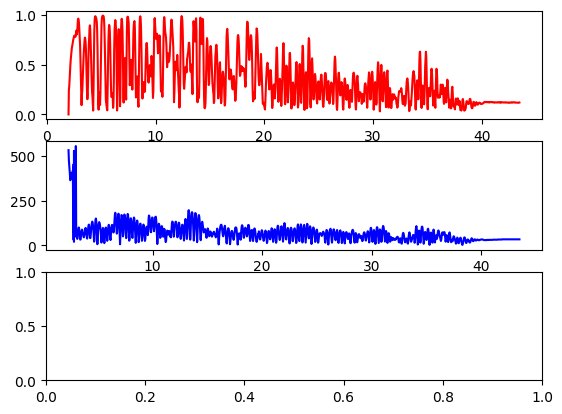

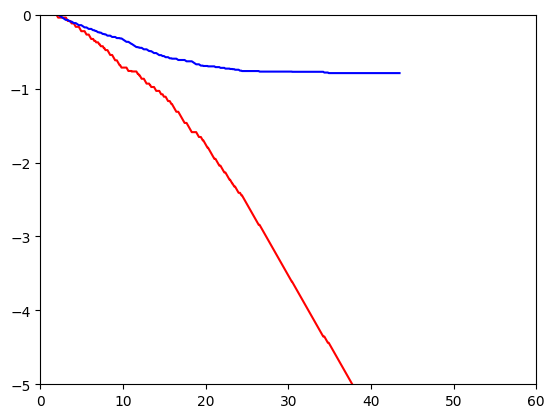

In [10]:
#reprocessed 892, 893
# 891, 892, 893?, 895, 896
fps=30.0
dq_white = -0.00656666666
dq_blue = -0.00253333333

path='E:/RawData/Mike/5050_beads/'
filename='P1001896.hdf5'
filename2 = filename[:-5] + '_fraction_data.csv'

print(path + filename)
mask = ((1096, 532), (1560, 844))

fraction_data = pd.read_csv(path + filename2, skiprows=0, index_col=0)
print(fraction_data)

# Bounces on white occur when fraction is less than 0.5 (ie blue facing up)
charge_white = np.cumsum(fraction_data.to_numpy() < 0.5) * dq_white
print(np.shape(charge_white))
charge_blue = np.cumsum(fraction_data.to_numpy() >= 0.5) * dq_blue
Delta_charge = np.subtract(charge_white,charge_blue)

tracking_data = pd.read_hdf(path + filename)
middle = (np.mean(tracking_data['x'][:-200]), np.mean(tracking_data['y'][:-200]))
tracking_data['dr'] = ((tracking_data['x'] - middle[0])**2 + (tracking_data['y'] - middle[1])**2)**0.5

fig, ax = plt.subplots(nrows=3,ncols=1)
ax[0].plot(fraction_data.index/fps, fraction_data.fraction,'r-')
ax[1].plot(tracking_data.index/fps, tracking_data.dr,'b-')
index_vals = tracking_data.index
#ax[2].plot(fraction_data.fraction.loc[index_vals], tracking_data.dr,'g.')
#ax[2].set_ylim([0,200])

fig, ax = plt.subplots(nrows=1,ncols=1)

ax.plot(fraction_data.index/fps, charge_white,'r-')
ax.plot(fraction_data.index/fps, charge_blue,'b-')

ax.set_xlim([0, 60])
ax.set_ylim([-5, 0])


### Extract heatmap from tracking data

num_pixels:
46372


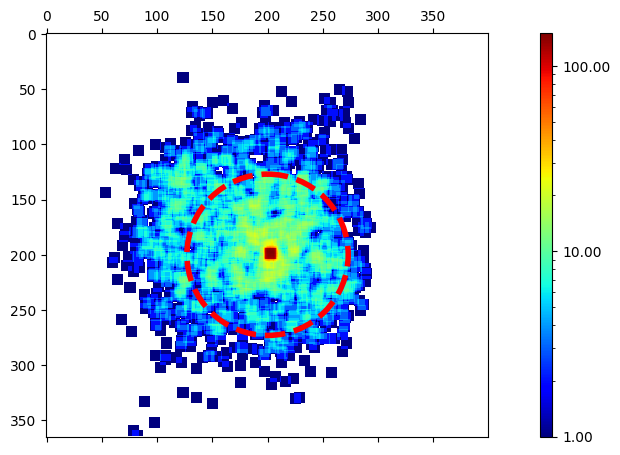

In [19]:
from labvision.video import ReadVideo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patch


def plot_heatmap(heatmap):
    print('num_pixels:')
    num_pixels = np.count_nonzero(heatmap)
    print(num_pixels)

    f = plt.figure(figsize=(6.2, 5.6))
    ax = f.add_axes([0.1, 0.1, 0.72, 0.72])
    axcolor = f.add_axes([0.90, 0.1, 0.02, 0.72])
    im = ax.matshow(heatmap, cmap='jet', norm=LogNorm(vmin=1, vmax=np.max(np.max(heatmap))))
    
    #find indices of max value in heatmap
    cy = np.argmax(np.sum(heatmap,axis=1))
    cx = np.argmax(np.sum(heatmap,axis=0))
    rad_px = int((1208-1062)/2)

    circ = patch.Circle((int(cx),int(cy)), radius=rad_px, fill=False, color='r', linestyle='--', linewidth=4)
    ax.add_patch(circ)

    #t = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    f.colorbar(im, cax=axcolor, format="%.2f")

def create_heatmap(filepath, crop=200):
    df = pd.read_hdf(filepath)    
    max_val = int(np.ceil(df['x'].max() if df['x'].max() > df['y'].max() else df['y'].max()))
    min_val = int(np.floor(df['x'].min() if df['x'].min() < df['y'].min() else df['y'].min()))
    diff = max_val - min_val

    heatmap = np.zeros((diff,diff))
    for idx, row in df.iterrows():
        x = int(row['x'])-min_val
        y = int(row['y']) - min_val
        heatmap[x-5:x+5,y-5:y+5] += 1

    #find indices of max value in heatmap
    cy = np.argmax(np.sum(heatmap,axis=1))
    cx = np.argmax(np.sum(heatmap,axis=0))
    heatmap = heatmap[cy-crop:cy+crop,cx-crop:cx+crop]

    plot_heatmap(heatmap)
    plt.show()

path='E:/RawData/Mike/5050_beads/'
filename='P1001895.hdf5'
create_heatmap(path + filename)